In [1]:
import stim
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

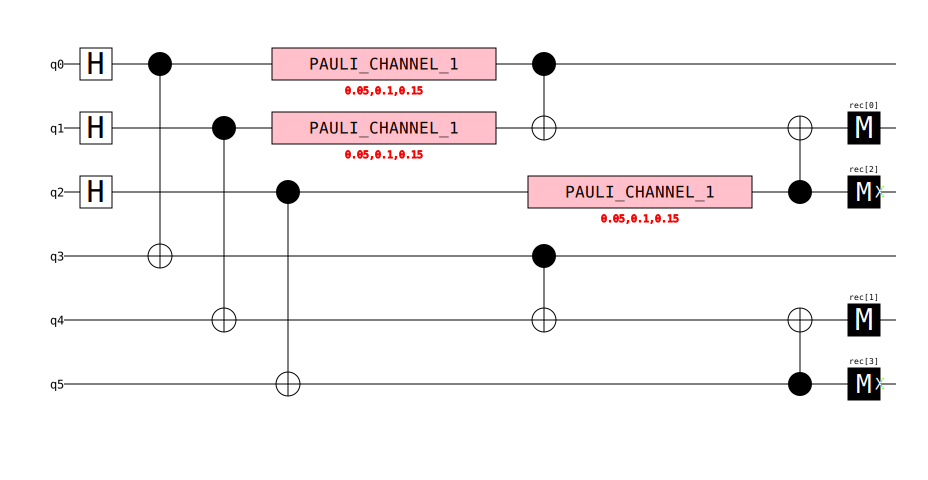

(array([ True,  True, False, ...,  True,  True,  True]),
 array([ True,  True, False, ...,  True,  True,  True]),
 array([ True,  True, False, ...,  True,  True,  True]))

In [2]:
def get_experiment_samples(px, py, pz, num_shots, show_circuit=False):
    circuit_string = f"""
    H 0 1 2
    CNOT 0 3 1 4 2 5
    PAULI_CHANNEL_1({px}, {py}, {pz}) 0 1 2
    CNOT 0 1 3 4
    CNOT 2 1 5 4
    MZ 1 4
    MX 2 5
    """
    circuit = stim.Circuit(circuit_string)
    sampler = circuit.compile_sampler()
    result = sampler.sample(shots=num_shots)
    if show_circuit:
        display(circuit.diagram('timeline-svg'))

    parr = np.einsum('ij->ji', result)
    zz_arr = ~(parr[0] ^ parr[1])
    xx_arr = ~(parr[2] ^ parr[3])
    joint_success_arr = zz_arr * xx_arr

    return zz_arr, xx_arr, joint_success_arr

get_experiment_samples(0.05, 0.1, 0.15, 10_000_000, show_circuit=True)

/var/folders/0j/tsyg7r_n3r75zkk3lg02j88c0000gn/T/ipykernel_23687/1705924367.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


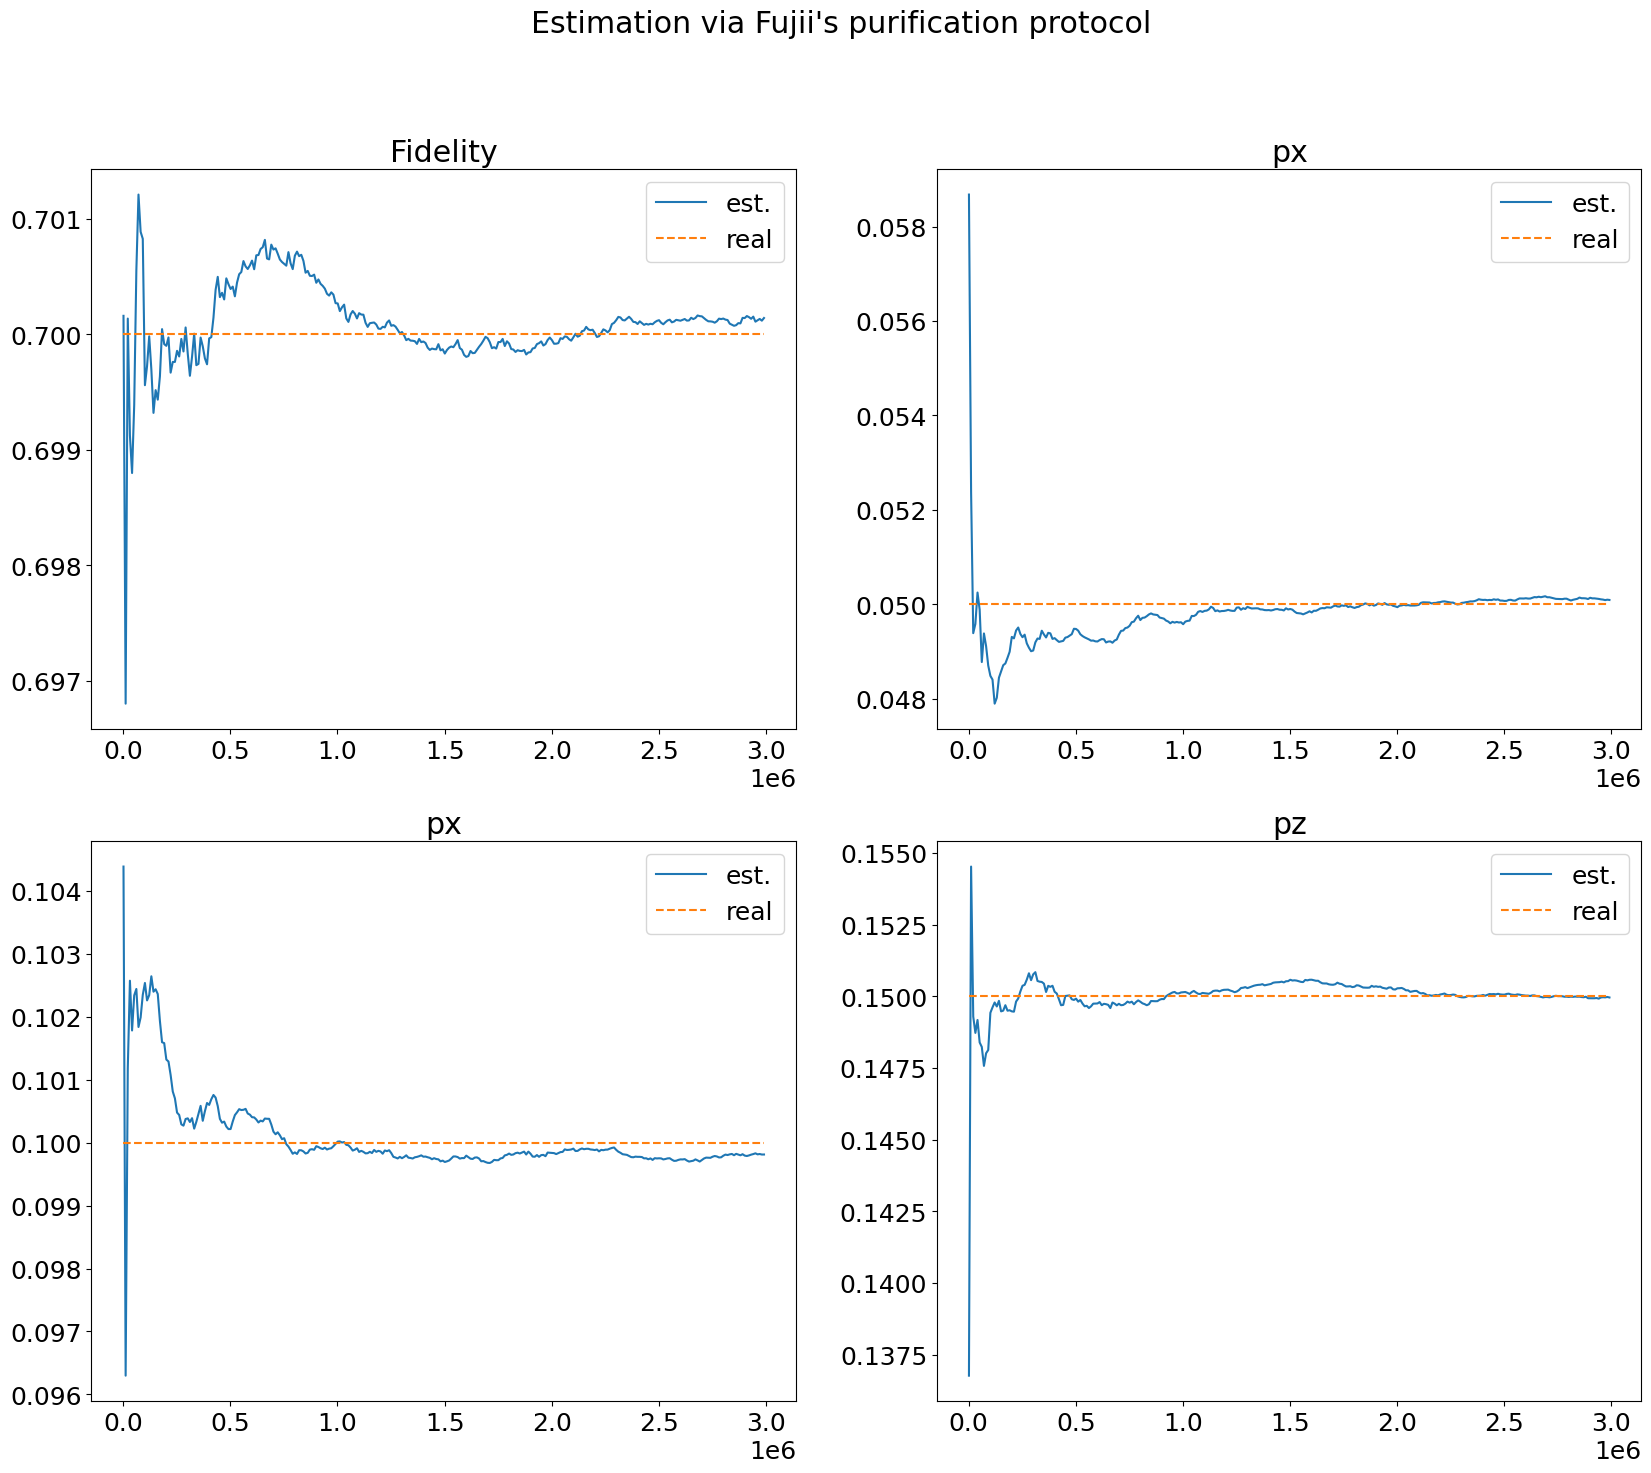

In [3]:
def get_bds_params(_cum_zz_arr, _cum_xx_arr, _cum_joint_arr, num_shots):
    x, y, z = sy.symbols('x y z', real=True)

    def get_var(n: int):
        if n == 0:
            return 1 - x - y - z
        if n == 1:
            return z
        if n == 2:
            return x
        if n == 3:
            return y

    expr = 0
    # joint probability
    for i in range(4):
        for j in range(4):
            for k in range(4):
                if ((i ^ j ^ k) & 2) == 0 and ((j ^ k) & 1) == 0:
                    expr += get_var(i) * get_var(j) * get_var(k)

    expr = sy.simplify(expr)

    eq1 = sy.Eq(_cum_zz_arr[num_shots-1] / num_shots, (1-x-y)**3 + 3*(1-x-y)*(x+y)**2)
    eq2 = sy.Eq(_cum_xx_arr[num_shots-1] / num_shots, (1-y-z)**2 + (y+z)**2)
    eq3 = sy.Eq(_cum_joint_arr[num_shots-1] / num_shots, expr)

    # return sy.nsolve((eq1, eq2, eq3), (x, y, z), (0, 0, 0))
    return np.array(sy.nsolve((eq1, eq2, eq3), (x, y, z), (0, 0, 0))).astype(np.float64).flatten()

def experiment_plot(px, py, pz, max_shots=10_000_000):
    # 4 plots, fidelity, px, py, and pz
    zz_arr, xx_arr, joint_arr = get_experiment_samples(px, py, pz, max_shots)
    zz_arr = np.cumsum(zz_arr)
    xx_arr = np.cumsum(xx_arr)
    joint_arr = np.cumsum(joint_arr)
    num_samples = np.arange(1000, max_shots + 1, 10000)
    estimated_params = [get_bds_params(zz_arr, xx_arr, joint_arr, j) for j in num_samples]
    estimated_params = np.einsum('ij->ji', estimated_params)
    # return estimated_params
    fidelities = 1 - estimated_params[0] - estimated_params[1] - estimated_params[2]
    
    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(2,2, figsize=(20,16))
    fig.suptitle("Estimation via Fujii's purification protocol")

    axs[0,0].plot(num_samples, fidelities, label='est.')
    axs[0,0].plot(num_samples, [1 - px - py - pz for _ in num_samples], '--', label='real')
    axs[0,0].set_title('Fidelity')
    # axs[0,0].set_yscale('log')
    axs[0,0].legend()

    axs[0,1].plot(num_samples, estimated_params[0], label='est.')
    axs[0,1].plot(num_samples, [px for _ in num_samples], '--', label='real')
    axs[0,1].set_title('px')
    # axs[0,1].set_yscale('log')
    axs[0,1].legend()

    axs[1,0].plot(num_samples, estimated_params[1], label='est.')
    axs[1,0].plot(num_samples, [py for _ in num_samples], '--', label='real')
    axs[1,0].set_title('px')
    # axs[1,0].set_yscale('log')
    axs[1,0].legend()

    axs[1,1].plot(num_samples, estimated_params[2], label='est.')
    axs[1,1].plot(num_samples, [pz for _ in num_samples], '--', label='real')
    axs[1,1].set_title('pz')
    # axs[1,1].set_yscale('log')
    axs[1,1].legend()

    fig.show()

experiment_plot(0.05, 0.1, 0.15, 3_000_000)